In [2]:
# Import libraries

# To manipulate and read/write data
import pandas as pd
import seaborn as sn
import numpy as np
import json

# To plot charts
import matplotlib.pyplot as plt
import folium as fl
from folium.plugins import TimeSliderChoropleth

In [3]:
# Read data
df = pd.read_csv('~/Data Science/Hong Kong House Price/data/cleaned data/cleaned_total_named_extract.csv')
hkg = '~/Data Science/Hong Kong House Price/data/hkg_adm1.geojson'

In [4]:
# Load Hong Kong geojson file for choropleth later
with open(hkg, encoding="utf8") as f: 
    map_data = f.readlines()
    map_data = [json.loads(line) for line in map_data]
map_data = map_data[0]

In [5]:
# Understand data structure
df.describe()
df.info()
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5154 entries, 0 to 5153
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  5154 non-null   int64  
 1   Date        5154 non-null   object 
 2   Area        5154 non-null   object 
 3   Name        5154 non-null   object 
 4   Years       5154 non-null   int64  
 5   Price..mm.  5154 non-null   float64
 6   Size.sqft.  5154 non-null   int64  
 7   Price/Sqft  5154 non-null   float64
dtypes: float64(2), int64(3), object(3)
memory usage: 322.2+ KB


Index(['Unnamed: 0', 'Date', 'Area', 'Name', 'Years', 'Price..mm.',
       'Size.sqft.', 'Price/Sqft'],
      dtype='object')

In [6]:
# Remove first column
df = df.drop(df.columns[0],axis = 1)
df.columns

Index(['Date', 'Area', 'Name', 'Years', 'Price..mm.', 'Size.sqft.',
       'Price/Sqft'],
      dtype='object')

In [7]:
# Change column name and data type
df.columns = ['Date', 'Area', 'Name', 'Years', 'Price(mm)', 'Size(sqft)','Price/Sqft']
df.Date = pd.to_datetime(df.Date, format = '%Y-%m-%d')
df['Price(mm)'] = pd.to_numeric(df['Price(mm)'])
df['Price/Sqft'] = pd.to_numeric(df['Price/Sqft'])

In [8]:
# Check date range and we confirm that the date ranges from March 04 to Aug 02
df.Date.describe()

<ipython-input-8-f999fcead6df>:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.Date.describe()


count                    5154
unique                     99
top       2021-06-04 00:00:00
freq                      104
first     2021-03-04 00:00:00
last      2021-08-02 00:00:00
Name: Date, dtype: object

Now we begin to explore the data. The main questions to explore from this data set are
- What is the housing transaction trend in Hong Kong Island across this period of time?
- Which area(s) is/are the most popular?
- Average price/sqft analysis.
- Which area and what building age have the highest potential to retain value?

Let us start our analysis from looking at trends across various areas. We define area that is the most popular by having the highest number of transaction during this period. Then we will study the trend of average price/sqft across various areas and try to identify which area has the highest retention value. We define area that has the highest retention value as area which old buildings are trading above average. 

In [9]:
# Which area is the most popular? 
group = df.groupby(df['Area'])
area = df.groupby('Area').agg(Num_transaction = ('Date','size'),Ave = ('Price/Sqft','mean')).sort_values(by = 'Num_transaction',ascending = False).reset_index()
area.head()

,Area,Num_transaction,Ave
0,North Point,485,16460.827060
1,Mid-Levels West,370,22259.022868
2,Wan Chai,353,19740.876540
3,Kennedy Town,328,19726.297613
4,Sai Wan Ho,307,18518.516760


Text(0.5, 1.0, 'Number of Transaction Across Areas')

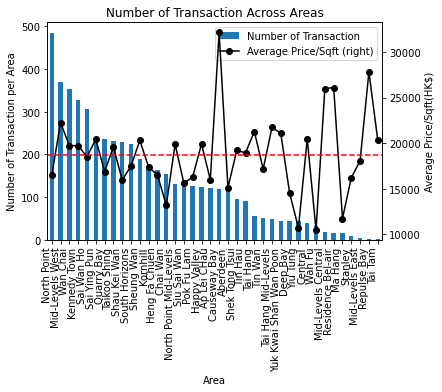

In [23]:
# Identifying trend for number of transaction and the average price/sqft through charts
ax1 = area.plot(x = 'Area', y = 'Num_transaction',kind= 'bar', label ='Number of Transaction',legend = True)
ax2 = area['Ave'].plot(secondary_y = True,color = 'k',marker = 'o',label ='Average Price/Sqft',legend = True)
plt.axhline(y = area['Ave'].mean(),color ='r', linestyle = '--')
ax1.set_ylabel('Number of Transaction per Area')
ax2.set_ylabel('Average Price/Sqft(HK$)')
ax2.set_xlabel('Area')
ax1.set_xticklabels(area.Area,rotation = 90,ha = 'right') 
ax2.set_title('Number of Transaction Across Areas')


In [10]:
area.sort_values(by = 'Ave',ascending = False).head()

,Area,Num_transaction,Ave
19,Causeway Bay,120,32176.022513
36,Repulse Bay,1,27830.188679
32,Residence Bel-air,16,26107.444176
31,Mid-Levels Central,19,25993.094724
1,Mid-Levels West,370,22259.022868


We can see that there is a sharp spike in average price/square feet(sqft) in Causeway Bay. Although there are expensive areas in Causeway Bay but 20% more expensive than Residence Bel-air or Midlevels Central, which are deemed as premium locations in Hong Kong Island, does seem a little off. This has been taken note of and we will investigate this point further.


In [34]:
# Now we want to study the trend between age of building and number of transaction and average price/sqft
# We first discover what is the age range of the building, and then we assign them into respective bins. 
df.Years.describe()

count    5153.000000
mean       32.255773
std        12.841008
min         1.000000
25%        25.000000
50%        33.000000
75%        41.000000
max        70.000000
Name: Years, dtype: float64

In [20]:
# Assigning building ages into respective age bin.
ranges = [0,10,20,30,40,50,60,70]
df['Bins'] = pd.cut(df['Years'],ranges)
age = df.groupby(['Bins']).agg(Ave_px = ('Price/Sqft','mean'),Num_tran = ('Price/Sqft','size')).reset_index()


Text(0.5, 1.0, 'Number of Transaction Across Building Age Groups')

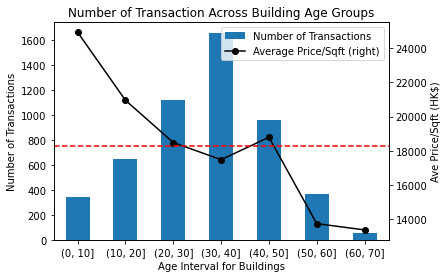

In [24]:
# Visualising trend based on building age
ax1 = age.plot(x = 'Bins', y = 'Num_tran',kind = 'bar', label = 'Number of Transactions',legend = True)
ax2 = age['Ave_px'].plot(secondary_y = True,color = 'k',marker = 'o',label = 'Average Price/Sqft',legend = True)
ax1.set_xlabel('Age Interval for Buildings')
ax1.set_ylabel('Number of Transactions')
ax2.set_ylabel('Ave Price/Sqft (HK$)')
plt.axhline(y = age['Ave_px'].mean(),color ='r', linestyle = '--')
ax1.set_title('Number of Transaction Across Building Age Groups')


Another anomaly found here. There is an unexpected spike in average price/sqft among 40-50year old buildings. We expect the trend to fall continuously hence this sudden spike above the mean price is worth investigating as well.

In [25]:
df.sort_values(by = 'Price/Sqft',ascending = False).head()

,Date,Area,Name,Years,Price(mm),Size(sqft),Price/Sqft,Bins
3166,2021-05-18,Causeway Bay,5 Sharp Street East,50,606.00,326,1.858896e+06,"(40, 50]"
4403,2021-04-19,Sai Ying Pun,King's Hill,4,43.93,955,4.600000e+04,"(0, 10]"
92,2021-07-23,Ap Lei CHau,Wai Fung Mansion,42,14.66,341,4.299120e+04,"(40, 50]"
664,2021-07-13,Shek Tong Tsui,Novum West,1,12.80,328,3.902439e+04,"(0, 10]"
2935,2021-05-25,Wan Chai,Star Crest,21,34.38,898,3.828508e+04,"(20, 30]"


Aha! Anomaly found! A unit in 5 Sharp Street East, Causeway Bay cost a whopping HKD1.86mm/sqft for a 50yo building. This quick detection of anomaly solves both mysteries of unexpected spike in average price/sqft in Causeway Bay and in 40-50year old building. A quick look on the Internet found out that a developer has been buying up walk up properties around Sharp Street, Causeway Bay. It is not unheard of in Hong Kong that a developer would pay extra to buy up residential units for newer development. Since this unit at 5 Sharp Street completely skews the chart, we decide to remove it.

In [26]:
# Removing anomaly from data
df.iloc[3166]
df = df.drop([3166]) 

Text(0.5, 1.0, 'Number of Transaction Across Areas')

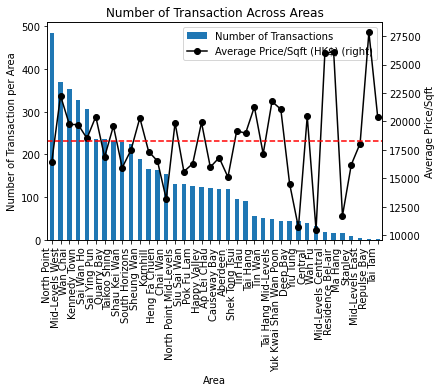

In [27]:
# Plotting area against number of transactions and average price/sqft with anomaly removed.
area = df.groupby('Area').agg(Num_transaction = ('Date','size'),Ave = ('Price/Sqft','mean')).sort_values(by = 'Num_transaction',ascending = False).reset_index()
ax1 = area.plot(x = 'Area', y = 'Num_transaction',kind= 'bar', label = 'Number of Transactions',legend = True)
ax2 = area['Ave'].plot(secondary_y = True,color = 'k',marker = 'o',label = 'Average Price/Sqft (HK$)', legend = True)
plt.axhline(y = area['Ave'].mean(),color ='r', linestyle = '--')
ax1.set_ylabel('Number of Transaction per Area')
ax2.set_ylabel('Average Price/Sqft')
ax2.set_xlabel('Area')
ax1.set_xticklabels(area.Area,rotation = 90,ha = 'right') 
ax2.set_title('Number of Transaction Across Areas')



Text(0.5, 1.0, 'Number of Transaction Across Building Age Groups')

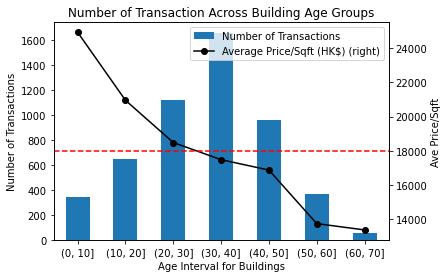

In [28]:
# Plotting building age groups against number of transactions and average price/sqft with anomaly removed.
age = df.groupby(['Bins']).agg(Ave_px = ('Price/Sqft','mean'),Num_tran = ('Price/Sqft','size')).reset_index()
ax1 = age.plot(x = 'Bins', y = 'Num_tran',kind = 'bar', label = 'Number of Transactions',legend = True)
ax2 = age['Ave_px'].plot(secondary_y = True,color = 'k',marker = 'o',label = 'Average Price/Sqft (HK$)', legend = True)
ax1.set_xlabel('Age Interval for Buildings')
ax1.set_ylabel('Number of Transactions')
ax2.set_ylabel('Ave Price/Sqft')
plt.axhline(y = age['Ave_px'].mean(),color ='r', linestyle = '--')
ax1.set_title('Number of Transaction Across Building Age Groups')


In [29]:
# To see the percentage change across age buckets for buildings.
age['Pct Change'] = age['Ave_px'].pct_change(periods =1) *100
age

,Bins,Ave_px,Num_tran,Pct Change
0,"(0, 10]",24933.868911,343,NaN
1,"(10, 20]",20957.434661,646,-15.947923
2,"(20, 30]",18486.462605,1121,-11.790432
3,"(30, 40]",17483.046301,1660,-5.427844
4,"(40, 50]",16875.917820,959,-3.472670
5,"(50, 60]",13744.191026,371,-18.557372
6,"(60, 70]",13376.630335,53,-2.674298


Now it makes more sense.The average price/sqft decreases with building age. We can see that the 30-40year old group is the most popular and a relative low decrease in average price/sqft (~ -3.5%) with the next subsequent age group. 

After identifying 30-40 year old buildings are the most popular age group, we would now investigate the change in transaction by time.

In [30]:
# Group transactions by date to analysis change with time.
date = df.groupby(df.Date).agg(Num_transaction = ('Date','size'),Ave = ('Price/Sqft','mean')).sort_values(by = 'Num_transaction',ascending = False)
date_gp = date.groupby([date.index.year,date.index.month]).agg(total_sum = ('Num_transaction','sum'),ave_price =('Ave','mean'))
date_gp.index = date_gp.index.rename(['Year','Month'])
date_gp['Month'] = date_gp.index

Text(0.5, 1.0, 'Trend change in Number of Transaction and Ave Price')

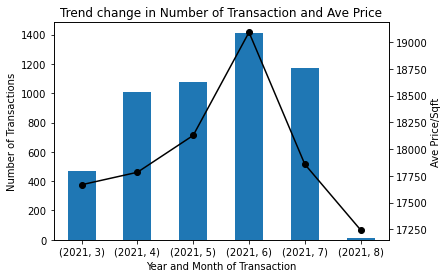

In [31]:
ax1 = date_gp.plot(x = 'Month',y = 'total_sum',kind='bar',legend = False)
ax2 = date_gp['ave_price'].plot(secondary_y = True,color='k',marker = 'o')
ax1.set_xlabel('Year and Month of Transaction')
ax1.set_ylabel('Number of Transactions')
ax2.set_ylabel('Ave Price/Sqft')
ax2.set_title('Trend change in Number of Transaction and Ave Price')


Remember our date ranges from March 4th to August 2nd, hence the sharp decrese in August is due to lack of transaction data for August in our dataset. We see that there is a clear increase in number of transaction and the average price/sqft in June. 

Another follow up question is what is driving the transaction in the month of June? Since Hong Kong is a 
financial hub. It is natural to look at the correlationship between the stock and housing market. 

<AxesSubplot:>

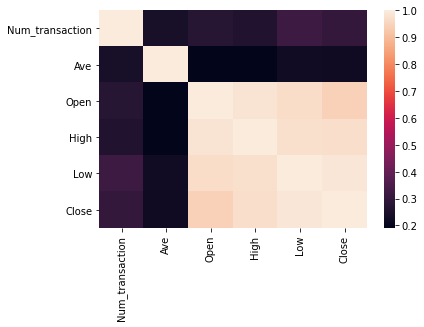

In [56]:
#HSI is a .csv file downloaded from HSI official page that contains the historical price of the index.
HSI = pd.read_csv('/Users/Kirsteenng_1/Data Science/Hong Kong House Price/HistoricalPrices.csv')
HSI['Date'] = pd.to_datetime(HSI.Date,format = '%m/%d/%y')
HSI.columns = ['Date','Open','High','Low','Close']
HSI.head()

HSI.Open = pd.to_numeric(HSI.Open)
HSI.High = pd.to_numeric(HSI.High)
HSI.Low = pd.to_numeric(HSI.Low)
HSI.Close = pd.to_numeric(HSI.Close)
stock_house = date.reset_index().merge(HSI.reset_index(),left_on = 'Date',right_on = 'Date')
stock_house = stock_house.drop(['index'],axis = 1)

# plot charts between HSI and housing transaction
corr_map2 = stock_house.corr()
stock_house['Ave'].corr(stock_house['Close'])
sn.heatmap(corr_map2)


It seems like the number of transaction and the Hang Seng Index do not have much correlationship (~0.22). On a deeper thought, it makes sense because the housing market is much less liquid than the stock market. If we have more data, it is suspected that we might see a lagged response from the financial market flowing into the real estate market in Hong Kong. However, due to the limitation of our dataset, we cannot conclude any correlationship between the stock and real estate markets. 


Now we identified 30-40yo buildings are the most popular due to its relatively medium average price/sqft. Now we will study which area has the best retention value for building of 30-40yo. We define areas that have good retention value when properties of that age range is trading above the average price/sqft.


In [63]:
old_df = df[df['Years'].between(30,40)]
old_df.groupby(['Years']).agg(Ave = ('Price/Sqft','mean'),Count = ('Price/Sqft','size')).reset_index()


,Years,Ave,Count
0,30,17801.816609,92
1,31,17934.577245,136
2,32,18224.046682,229
3,33,16755.542963,250
4,34,17431.412142,208
5,35,18342.544051,253
6,36,17963.672196,126
7,37,17140.552608,56
8,38,16919.233185,110
9,39,16882.053647,121


In [65]:
old_df.groupby(['Years']).agg(Ave = ('Size(sqft)','mean'),Count = ('Size(sqft)','size')).reset_index()
d = old_df.groupby(['Area','Years']).agg(Ave = ('Price/Sqft','mean'),Count = ('Price/Sqft','size')).reset_index().sort_values(['Area','Ave'],ascending = False)
d

,Area,Years,Ave,Count
158,Wan Chai,31,22510.785242,10
157,Wan Chai,30,22439.497504,3
159,Wan Chai,32,21482.500576,8
160,Wan Chai,33,19230.620416,15
163,Wan Chai,36,17965.456411,6
...,...,...,...,...
1,Aberdeen,33,16101.404815,4
0,Aberdeen,32,16057.246711,8
2,Aberdeen,35,15125.494695,4
5,Aberdeen,39,14578.284570,21


We see that buildings of 30-40yo in Happy Valley, Midlevel West, Causewaybay are trading above overall average of $18,565. Hence we can interpret those areas as high value retention area even for old buildings ie 30-40yo buildings.
Since our area of interest is Wanchai, we zoom in and study the trend in Wanchai. 


In [68]:
d[d['Area']=='Wan Chai'].sort_values('Years')

,Area,Years,Ave,Count
157,Wan Chai,30,22439.497504,3
158,Wan Chai,31,22510.785242,10
159,Wan Chai,32,21482.500576,8
160,Wan Chai,33,19230.620416,15
161,Wan Chai,34,17953.376194,3
162,Wan Chai,35,16584.676837,3
163,Wan Chai,36,17965.456411,6
164,Wan Chai,39,16243.452830,5
165,Wan Chai,40,15913.522625,9


So if one's goal is to buy a 31yo property in Wanchai, then one should liquidate it before 34-35yo as it deteriorates quickly in terms of price/sqft in the latter age range.

In conclusion, 
- North Point is the most popular area by number of transaction.
- 30-40year old buildings are the most popular buildings because they have the most optimum retention value in price/sqft.
- Happy Valley, Midlevel West, Causewaybay have the highest retention value for old buildings.

There are alot of limitations in this study as we do not have sufficient data in terms of number of transactions collected and features on the collected data. For instance, if we have the price trend of each building since its inception, that would contribute better for us to quantitatively judge the retention value of a building as we can measure the change of its price since the beginning. Secondly, rental prices on these properties would be another good quantitative indicator of retention value as well. These features will be added in future version of this study.